**Prénom** : Mohamed  
**Nom** : JARMOUNI

We are given the dataset meatspec, see https://rdrr.io/cran/faraway/man/meatspec.html for
details; we are trying to predict the value of variable f at with some covariates X (as columns) for which
there are n i.i.d. measurements (as the rows of the data provided) over p covariates. However, it is not
clear whether all the covariates are relevant for the prediction of Y . In this project, we are going to consider
several variants of the OLS to make a regressor under this setting and identify relevant variables

### Importations

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math as m
import seaborn as sb
import sklearn.linear_model as lm
import scipy.stats

import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA


#### Data preprocessing

In [250]:
np.random.seed(0)
raw_data = pd.read_csv("meatspec.csv")
raw_data.head()
#raw_data["fat"]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


In [251]:
raw_data.mean()

V1       2.808561
V2       2.811137
V3       2.813727
V4       2.816363
V5       2.819098
          ...    
V97      3.081070
V98      3.062290
V99      3.043548
V100     3.024895
fat     18.142326
Length: 101, dtype: float64

**Data is not centered, because :**

In [252]:
raw_data.mean().max()==0

False

In [253]:
raw_data.std()

V1       0.410793
V2       0.413352
V3       0.415906
V4       0.418465
V5       0.421040
          ...    
V97      0.539730
V98      0.538586
V99      0.537108
V100     0.535354
fat     12.740297
Length: 101, dtype: float64

**Data is not normalized, so Data is not standardized**

In [254]:
raw_data.std().max()==1

False

**We will first standardize our data, but since the fit_transform method returns numpy array , we will re-transform back the standardized data into a dataframe**

In [255]:
data_train, data_test = train_test_split(raw_data, test_size=0.25)

In [256]:
scaler = StandardScaler()

std_data_train = scaler.fit_transform(data_train)
std_data_test = scaler.transform(data_test)

std_data_train.shape

(161, 101)

In [257]:
A=["V"+str(i) for i in range(1,101)]
std_data_train = pd.DataFrame(std_data_train, columns = A+["fat"])
std_data_test = pd.DataFrame(std_data_test, columns = A+["fat"])

**For the rest of the Lab we will work on the following sets :  (for both training and testing)**

In [258]:
X_train = std_data_train.drop(columns=["fat"])
Y_train = std_data_train["fat"]

X_test = std_data_test.drop(columns = ["fat"])
Y_test = std_data_test["fat"]

In [259]:
X = X_train
Y = Y_train

model = LinearRegression()
reg = model.fit(X, Y)

reg.score(X_test, Y_test)

0.9600547777987571

**We don't need to fit the intercept because we have standardized the data. And even if we fit it, we find it to be very small**

In [260]:
reg.intercept_

6.190871826255708e-12

**We get the following R² score of 0.96** :

In [261]:
#model.score(X,Y)
r_2 = reg.score(X_test, Y_test)
r_2

0.9600547777987571

In [262]:
df_coef = pd.DataFrame([r_2], columns=["OLS"])
df_coef

,OLS
0,0.960055


## Variable Selection

**We will not define the stop criterion for the method so our method will keep adding variables at each time until all the variables are used**

**We also use the formula of the test statistic of no effet that we have seen in the course**

In [263]:
r = Y_train
X = X_train
n = X.shape[0]

Selected=[]
pvalues=[]
S = [i for i in range(1,101)] 
# S will be a decreasing list and will represent the deletion of every selected covariate
        
for i in range(1,101) :
    
    kmax = 1
    Tmax = -m.inf
    
    for k in S :
        
        X_k = sm.add_constant(X["V"+str(k)])
        model_k = lm.LinearRegression(fit_intercept=False).fit(X_k, r)
        
        # we compute the elements of the Test statistic formula : sk, theta ...
        theta_k = model_k.coef_
        G_k = np.dot(X_k.T, X_k) / n
        s_k = np.linalg.inv(G_k)[0][0]
        sigma_k = np.linalg.norm(r - X_k @ theta_k)**2 / (n-2)
        T_k = (np.sqrt(n)*np.linalg.norm(theta_k, 1)) / (np.sqrt(s_k) * sigma_k)
        
        if(T_k >= Tmax) : # We find the highest Tn_k value along with it's respective k index
            Tmax = T_k
            kmax = k
    
    Vkmax = "V"+str(kmax)
    Selected += [Vkmax]
    pv = 2*(1-scipy.stats.t.cdf(np.abs(Tmax), n-2))
    pvalues += [pv]
    model_kmax = sm.OLS(r, X[Vkmax]).fit()
    theta_kmax = model_kmax.params[Vkmax]
    r = r.sub(X[Vkmax].multiply(theta_kmax)) 
    S.remove(kmax)
        

**We select the following covariates in the following order**

In [264]:
print("The selected features :" + str(Selected))
print("\n")
print("Their respective pvalues :" + str(pvalues))

The selected features :['V41', 'V8', 'V40', 'V7', 'V42', 'V9', 'V39', 'V6', 'V43', 'V10', 'V38', 'V5', 'V37', 'V11', 'V98', 'V4', 'V44', 'V12', 'V36', 'V3', 'V97', 'V13', 'V99', 'V14', 'V35', 'V2', 'V45', 'V1', 'V96', 'V15', 'V34', 'V16', 'V100', 'V17', 'V33', 'V18', 'V95', 'V19', 'V94', 'V20', 'V46', 'V65', 'V32', 'V66', 'V93', 'V64', 'V92', 'V67', 'V91', 'V68', 'V31', 'V21', 'V90', 'V63', 'V89', 'V69', 'V47', 'V62', 'V88', 'V70', 'V87', 'V61', 'V86', 'V54', 'V30', 'V53', 'V85', 'V71', 'V84', 'V55', 'V29', 'V60', 'V83', 'V22', 'V48', 'V56', 'V82', 'V59', 'V28', 'V52', 'V81', 'V72', 'V27', 'V57', 'V80', 'V58', 'V49', 'V73', 'V79', 'V51', 'V26', 'V23', 'V78', 'V74', 'V25', 'V75', 'V77', 'V76', 'V50', 'V24']


Their respective pvalues :[0.0, 0.018804495885289985, 0.018639511040842827, 0.01771133582936546, 0.018364151481200075, 0.017633914205033907, 0.018471758544450934, 0.01778875155770443, 0.02171296986937299, 0.021164349764120072, 0.02106813834446397, 0.020702948048855196, 0.0278025762

In [265]:
fvs = pd.Series(data=pvalues, index=Selected)
fvs

V41    0.000000
V8     0.018804
V40    0.018640
V7     0.017711
V42    0.018364
         ...   
V75    0.928716
V77    0.945698
V76    0.971327
V50    0.977857
V24    0.977856
Length: 100, dtype: float64

**The list of covariates that satisfies the condition of p value < 0.05 is :**

In [266]:
fvs[fvs<0.05]

V41    0.000000
V8     0.018804
V40    0.018640
V7     0.017711
V42    0.018364
V9     0.017634
V39    0.018472
V6     0.017789
V43    0.021713
V10    0.021164
V38    0.021068
V5     0.020703
V37    0.027803
V11    0.027159
V98    0.030912
V4     0.035091
V44    0.032253
V12    0.031678
V36    0.035811
V3     0.036981
V97    0.041061
V13    0.044777
V99    0.049219
dtype: float64

**We run the OLS on the selected features**

In [267]:
indices = fvs[fvs <0.05].index
X = std_data_train[indices]
Y = Y_train
model_fvs = LinearRegression()
reg_fvs = model_fvs.fit(X, Y)
r_2_fvs = reg_fvs.score(std_data_test[indices], Y_test )
r_2_fvs

0.9551797946015067

**We get R² = 0.955  value for this OLS after Forward variable selection**

In [268]:
df_coef["FVS before OLS"]=[r_2_fvs]
df_coef

,OLS,FVS before OLS
0,0.960055,0.95518


**In the previous question, The FVS allowed us to select 23 covariates so we will use the sequential selector with the same number of features to select**

In [269]:
X = X_train
Y = Y_train

model = LinearRegression()

seqselector = SequentialFeatureSelector(model, n_features_to_select=23, direction='forward')

X_selected = seqselector.fit_transform(X, Y)

is_selected_features = seqselector.get_support()

In [270]:
selected_features=[]
# Here we transform the previous array which is a boolean array into an array containing the chosen covariates
for i in range(0,100):
    if is_selected_features[i]==True :
        selected_features+=["V"+str(i+1)]
print("The selected features using sequential selector : " )
selected_features

The selected features using sequential selector : 


['V1',
 'V2',
 'V4',
 'V8',
 'V15',
 'V19',
 'V20',
 'V22',
 'V35',
 'V40',
 'V41',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V58',
 'V75',
 'V88',
 'V91',
 'V98',
 'V100']

**We do not get the same selected features because :**

**The forward selection method starts with an empty set of features and iteratively adds one feature at a time, selecting the feature that results in the best performance on the validation set. The sequential selection method, on the other hand, starts with the full set of features and iteratively removes one feature at a time, selecting the feature to remove based on its contribution to the model.**

**As a result, the forward selection method and the sequential selection method can select different subsets of features because they search through the space of possible feature subsets in different ways. The forward selection method tends to select fewer features than the sequential selection method because it starts with an empty set and only adds features that improve performance.**

**We run the OLS after the sequential feature select and we get the following R² score :**

In [271]:
X = std_data_test.drop(columns=["fat"])[selected_features]
Y = Y_test
model = LinearRegression()
reg = model.fit(X, Y)
reg.score(X, Y)

0.988182052170004

In [272]:
df_coef["SequentialVS before OLS"]=[reg.score(X,Y)]
df_coef

,OLS,FVS before OLS,SequentialVS before OLS
0,0.960055,0.95518,0.988182


## Ridge :

**First let's code the function Ridge that returns the ridge estimator, using the formula we've seen in the course.**

In [273]:
X = X_train
Y = Y_train

def Ridge(X,Y,alpha) :
    n = X.shape[0]
    p = X.shape[1]
    return np.linalg.inv(n*alpha*np.identity(p) + (X.T @ X))@((X.T)@Y)


**a/**    

In [274]:
ALPHA = np.logspace(-9, 2, 50)
thetas = pd.DataFrame()
i=1
for alpha in ALPHA :
    R = Ridge(X,Y,alpha)
    thetas["alpha"+str(i)]= R
    i+=1

thetas


,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,alpha10,...,alpha41,alpha42,alpha43,alpha44,alpha45,alpha46,alpha47,alpha48,alpha49,alpha50
0,252.002963,229.204576,199.136942,164.086239,127.746471,93.881122,65.222523,43.069927,27.395036,17.160150,...,-0.036400,-0.023201,-0.013523,-0.006897,-0.002622,-0.000032,0.001393,0.002021,0.002112,0.001874
1,-257.259762,-213.466106,-167.545814,-124.311949,-87.609473,-59.212117,-38.834325,-24.940433,-15.710002,-9.644637,...,-0.037411,-0.023793,-0.013872,-0.007103,-0.002744,-0.000105,0.001350,0.001995,0.002097,0.001865
2,39.264019,16.470324,-3.386608,-16.170726,-21.273708,-20.620755,-16.943358,-12.513396,-8.647254,-5.789020,...,-0.038318,-0.024322,-0.014182,-0.007286,-0.002853,-0.000169,0.001312,0.001972,0.002083,0.001857
3,50.022261,17.747725,-4.200301,-17.100121,-22.289564,-21.861820,-18.325359,-13.879691,-9.919777,-6.973993,...,-0.039131,-0.024792,-0.014457,-0.007448,-0.002948,-0.000226,0.001278,0.001952,0.002071,0.001850
4,-237.123885,-190.567605,-150.103169,-114.943403,-85.347502,-61.474989,-43.054269,-29.476835,-19.949981,-13.573653,...,-0.039823,-0.025188,-0.014686,-0.007582,-0.003027,-0.000272,0.001250,0.001936,0.002062,0.001845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,43.416753,32.260745,19.048113,4.543230,-8.635329,-17.971253,-22.530147,-22.995311,-20.846582,-17.573999,...,0.040069,0.029222,0.020895,0.014979,0.010968,0.008282,0.006429,0.005052,0.003930,0.002962
96,-166.241912,-140.903725,-119.328173,-101.017177,-84.640848,-69.186300,-54.519537,-41.188710,-29.876052,-20.969590,...,0.040854,0.029757,0.021240,0.015195,0.011100,0.008361,0.006476,0.005080,0.003947,0.002972
97,-76.262818,-82.789362,-86.724952,-84.082891,-74.768857,-61.180912,-46.307588,-32.546072,-21.287186,-12.939189,...,0.040989,0.029878,0.021328,0.015253,0.011136,0.008383,0.006489,0.005088,0.003951,0.002974
98,-41.436380,-53.796649,-53.966678,-46.114465,-34.275199,-21.825116,-10.969028,-2.693487,2.911314,6.251193,...,0.040440,0.029565,0.021146,0.015146,0.011072,0.008345,0.006466,0.005073,0.003942,0.002969


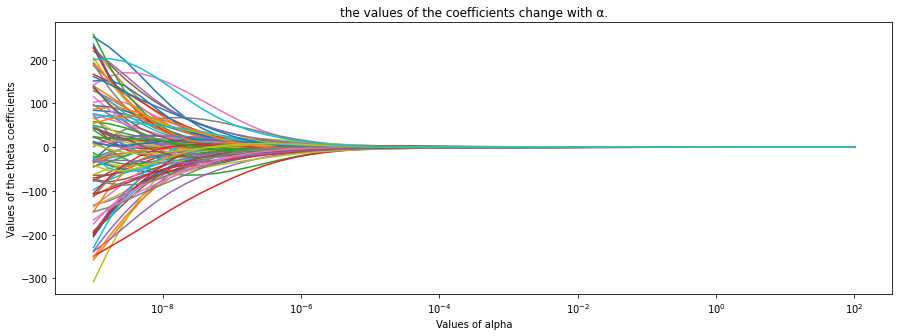

In [275]:
ax = plt.figure(figsize=(15,5))
for i in range(0,100):
    plt.plot(ALPHA, thetas.loc[i].to_numpy())
plt.xscale('log')
plt.xlabel("Values of alpha")
plt.ylabel("Values of the theta coefficients")
plt.title("the values of the coefficients change with α.")
plt.show()

**b/   Let's compute the MSE for each value of alpha**

In [276]:
Y_train_true = std_data_train["fat"].to_numpy()
Y_test_true = std_data_test["fat"].to_numpy()
MSE_train = []
MSE_test = []

for k in range(1,len(ALPHA)+1) :
    Y_train_predict = std_data_train.drop(columns = ["fat"]).to_numpy()@thetas["alpha"+str(k)].to_numpy()
    Y_test_predict = std_data_test.drop(columns = ["fat"]).to_numpy()@thetas["alpha"+str(k)].to_numpy()
    
    MSE_train += [mean_squared_error(Y_train_true, Y_train_predict)]
    MSE_test += [mean_squared_error(Y_test_true, Y_test_predict)]

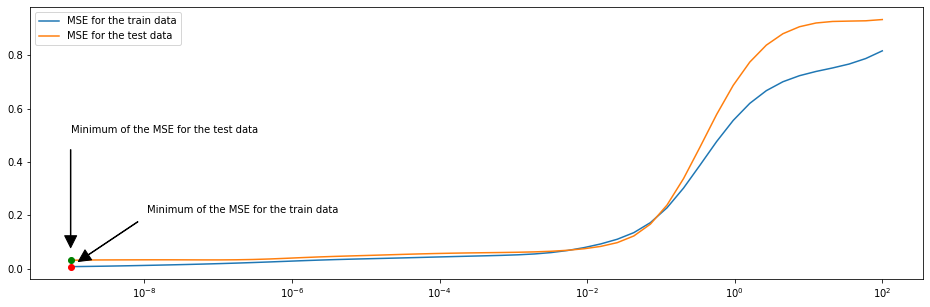

In [277]:
ax = plt.figure(figsize=(16,5))

plt.plot(ALPHA, MSE_train, label = "MSE for the train data")
plt.plot(ALPHA, MSE_test, label = "MSE for the test data")

plt.xscale("log")

plt.plot(ALPHA[0],MSE_train[0], marker='o', color='r')
plt.plot(ALPHA[0],MSE_test[0], marker='o', color='green')
plt.annotate('Minimum of the MSE for the train data', xy=(ALPHA[0], MSE_train[0]), xytext=(ALPHA[0]+10e-9,MSE_train[0]+0.2),arrowprops=dict(facecolor='black',width=0.5, shrink=0.1))
plt.annotate('Minimum of the MSE for the test data', xy=(ALPHA[0], MSE_test[0]), xytext=(ALPHA[0],MSE_train[0]+0.5),arrowprops=dict(facecolor='black',width=0.5, shrink=0.1))

plt.legend()
plt.show()

**c/ The best performing value of alpha is 10^-9 which is "alpha1", we have the following respective estimator that is thetas["alpha1"] so we compute the value of the R² score:**

In [278]:
theta = thetas["alpha1"]
Y_test_true = Y_test.to_numpy()
Y_test_predict = X_test.to_numpy()@theta
r2_ridge = r2_score(Y_test_true, Y_test_predict)
df_coef["Ridge"]=[r2_ridge]
df_coef

,OLS,FVS before OLS,SequentialVS before OLS,Ridge
0,0.960055,0.95518,0.988182,0.968269


## Cross-validation, lasso and elastic net

**The code shows warning because : Objective did not converge in the coordinate descent. Hence we need to increase the max_iteration untill we reach the objective**

In [279]:
ALPHA = np.logspace(-5, -2, 50)
MSE_train = []
MSE_test = []
nb_nonzero = []

X = X_train
Y = Y_train
X_test = std_data_test.drop(columns = ["fat"])
Y_test_true = Y_test

for alpha in ALPHA:
    lasso = Lasso(alpha=alpha, max_iter=100000, tol = 0.05)
    lasso.fit(X, Y)
    A = lasso.coef_
    
    nonzeros = np.count_nonzero(A)
    nb_nonzero += [nonzeros]
    
    Y_train_predict = lasso.predict(X)
    Y_test_predict = lasso.predict(X_test)
    
    mse_train = mean_squared_error(Y, Y_train_predict)
    mse_test = mean_squared_error(Y_test_true, Y_test_predict)
    
    MSE_train += [mse_train]
    MSE_test += [mse_test]
    


**Let's plot the number of coefficients that are different from 0 for each value of α.**

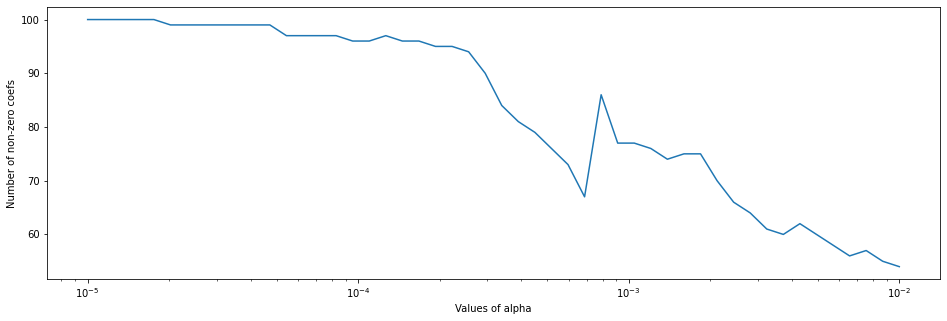

In [280]:
ax = plt.figure(figsize=(16,5))
plt.plot(ALPHA, nb_nonzero, label = "The number of coefficient different from 0 in the estimator")
plt.xscale("log")
plt.ylabel("Number of non-zero coefs")
plt.xlabel("Values of alpha")
plt.show()

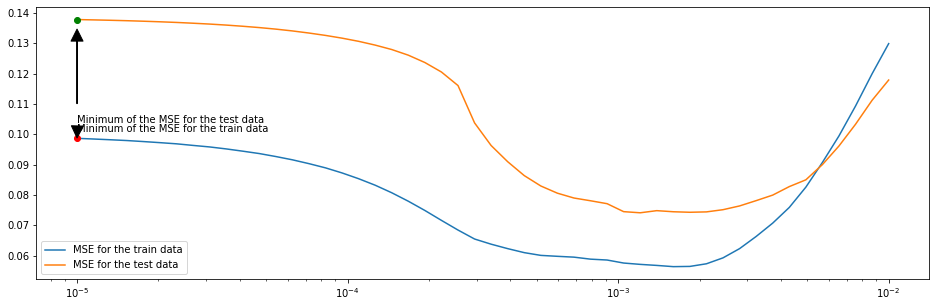

In [281]:
ax = plt.figure(figsize=(16,5))
plt.plot(ALPHA, MSE_train, label = "MSE for the train data")
plt.plot(ALPHA, MSE_test, label = "MSE for the test data")
plt.xscale("log")
plt.plot(ALPHA[0],MSE_train[0], marker='o', color='r')
plt.plot(ALPHA[0],MSE_test[0], marker='o', color='green')
plt.annotate('Minimum of the MSE for the train data', xy=(ALPHA[0], MSE_train[0]), xytext=(ALPHA[0]+10e-9,MSE_train[0]+0.002),arrowprops=dict(facecolor='black',width=0.5, shrink=0.1))
plt.annotate('Minimum of the MSE for the test data', xy=(ALPHA[0], MSE_test[0]), xytext=(ALPHA[0],MSE_train[0]+0.005),arrowprops=dict(facecolor='black',width=0.5, shrink=0.1))
plt.legend()
plt.show()

### Question 7 :

In [282]:
K = 10
ALPHA = np.logspace(-10,3,50)

In [283]:

MeanError = pd.DataFrame()

for L2 in [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99] :

    Errors = pd.DataFrame()
    fold = int(X_train.shape[0]/K)

    for k in range(0,K):
        
        X_modelk_train = X_train.drop([i for i in range(k*fold, (k+1)*fold+1)])
        Y_modelk_train = Y_train.drop([i for i in range(k*fold, (k+1)*fold+1)])
        X_modelk_test = X_train.iloc[k*fold: (k+1)*fold+1]
        Y_modelk_test = Y_train.iloc[k*fold: (k+1)*fold+1]
        
        err = []
        for L1 in ALPHA :
            modelk = ElasticNet(alpha = L1+L2 , l1_ratio= (L2/(L1+L2))).fit(X_modelk_train, Y_modelk_train)
            Y_modelk_predict = modelk.predict(X_modelk_test)
            
            e = mean_squared_error(Y_modelk_test, Y_modelk_predict)
            err += [e]
        Errors["Validation fold n"+str(k+1)]=err
    
    MeanError_L2 = Errors.mean(axis=1)
    MeanError["L2 = "+str(L2)]=MeanError_L2
    
        
        
        
    

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.993e+00, tolerance: 1.508e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.993e+00, tolerance: 1.508e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.000e+01, tolerance: 1.508e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.001e+01, tolerance: 1.508e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.940e+01, tolerance: 1.508e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.516e+01, tolerance: 1.508e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+01, tolerance: 1.500e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+01, tolerance: 1.500e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+01, tolerance: 1.500e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+01, tolerance: 1.500e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.522e+01, tolerance: 1.500e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.687e+01, tolerance: 1.500e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.869e+00, tolerance: 1.406e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.869e+00, tolerance: 1.406e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.246e+00, tolerance: 1.406e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.565e+00, tolerance: 1.406e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.541e+01, tolerance: 1.406e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.683e+01, tolerance: 1.406e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.452e+00, tolerance: 1.425e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.452e+00, tolerance: 1.425e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e+01, tolerance: 1.425e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.637e+01, tolerance: 1.425e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+01, tolerance: 1.413e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+01, tolerance: 1.413e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.083e+01, tolerance: 1.413e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+01, tolerance: 1.413e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.575e+01, tolerance: 1.413e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.845e+01, tolerance: 1.413e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.747e+00, tolerance: 1.403e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.747e+00, tolerance: 1.403e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.184e+01, tolerance: 1.403e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.268e+01, tolerance: 1.403e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.672e+01, tolerance: 1.403e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.888e+01, tolerance: 1.403e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.426e+00, tolerance: 1.304e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.426e+00, tolerance: 1.304e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.261e+01, tolerance: 1.304e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e+01, tolerance: 1.304e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.937e+01, tolerance: 1.304e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.139e+01, tolerance: 1.304e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.084e+01, tolerance: 1.394e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.085e+01, tolerance: 1.394e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e+01, tolerance: 1.394e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.181e+01, tolerance: 1.394e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.676e+01, tolerance: 1.394e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.799e+01, tolerance: 1.394e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.028e+01, tolerance: 1.512e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e+01, tolerance: 1.512e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.240e+01, tolerance: 1.512e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.768e+01, tolerance: 1.512e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.061e+01, tolerance: 1.441e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.061e+01, tolerance: 1.441e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e+01, tolerance: 1.441e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.065e+01, tolerance: 1.441e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.471e+01, tolerance: 1.441e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mohamed/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.911e+01, tolerance: 1.441e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

**We get the following table in which every row is for a different value of L1 which goes from 10^(-10) to 10³**

In [284]:
MeanError

,L2 = 0,L2 = 0.1,L2 = 0.5,L2 = 0.7,L2 = 0.9,L2 = 0.95,L2 = 0.99
0,0.167207,0.721407,1.015561,1.062582,1.062582,1.062582,1.062582
1,0.167207,0.721407,1.015561,1.062582,1.062582,1.062582,1.062582
2,0.167207,0.721407,1.015561,1.062582,1.062582,1.062582,1.062582
3,0.167207,0.721407,1.015561,1.062582,1.062582,1.062582,1.062582
4,0.167207,0.721407,1.015561,1.062582,1.062582,1.062582,1.062582
5,0.167207,0.721407,1.015561,1.062582,1.062582,1.062582,1.062582
6,0.167207,0.721407,1.015561,1.062582,1.062582,1.062582,1.062582
7,0.167207,0.721407,1.015561,1.062582,1.062582,1.062582,1.062582
8,0.167206,0.721407,1.015561,1.062582,1.062582,1.062582,1.062582
9,0.167205,0.721407,1.015561,1.062582,1.062582,1.062582,1.062582


**We plot the variation of the error according to both values of L1 and L2**

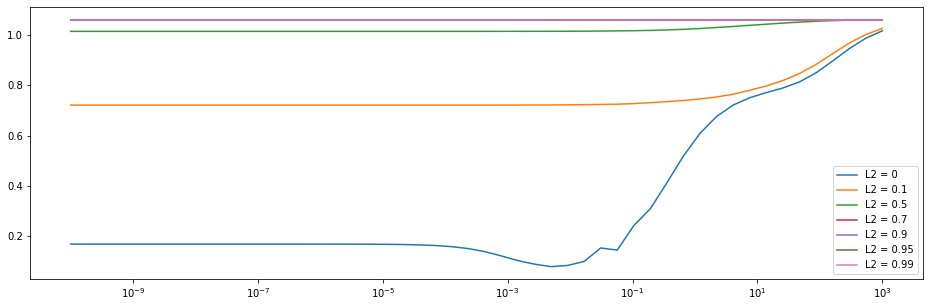

In [285]:
plt.figure(figsize=(16,5))
for k in [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99] :
    plt.plot(ALPHA, MeanError["L2 = "+str(k)], label="L2 = "+str(k))
plt.xscale("log")
plt.legend()
plt.show()

**We run a linear regression for the covariate V40 and get the following regression line**

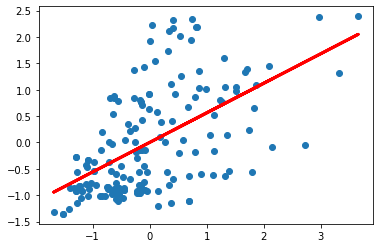

In [286]:

Y = Y_train.to_numpy()
X_40 = X_train["V40"].to_numpy()

model = LinearRegression().fit(X_40.reshape(-1, 1), Y)

plt.scatter(X_40, Y)
plt.plot(X_40, model.predict(X_40.reshape(-1, 1)), color='red', linewidth=3)
plt.show()

**a/ Heat map of the covariance**

**We use the course formula on how to compute the covariance using svd**

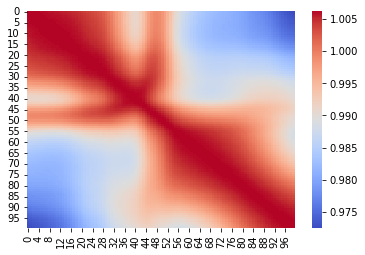

In [287]:

X = std_data_train.drop(columns = ["fat"]).to_numpy()
Y = std_data_train["fat"].to_numpy()

Cov = np.cov(X.T)

U, s, V = np.linalg.svd(Cov)

sb.heatmap(np.abs(Cov), cmap='coolwarm')
plt.show()


**d/**

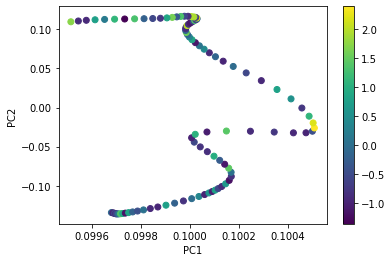

In [288]:
pca = PCA(n_components=2).fit(X)
X_proj = pca.components_

plt.scatter(X_proj[0].T, X_proj[1].T, c=Y[:100])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

Interpretation :

**e/**

In [289]:
n = X.shape[1]
k_values = range(2, n+1)

results = pd.DataFrame(index=k_values, columns=['R2'])


for k in k_values:
    pca = PCA(n_components=k).fit(X)
    X_proj = pca.components_.T
    X_proj_train = X_proj[:75,:]
    X_proj_test = X_proj[75:,:]
    model = LinearRegression()
    model.fit(X_proj_train, Y[:75])
    Y_pred = model.predict(X_proj_test)
    r2 = r2_score(Y_pred, Y[75:100])
    results.loc[k, 'R2'] = r2


df_coef["PCA"]=[results.max()["R2"]]
df_coef

,OLS,FVS before OLS,SequentialVS before OLS,Ridge,PCA
0,0.960055,0.95518,0.988182,0.968269,0.12796


### Summary

**We get the following score table :**

In [290]:
df_coef

,OLS,FVS before OLS,SequentialVS before OLS,Ridge,PCA
0,0.960055,0.95518,0.988182,0.968269,0.12796


**OLS:** Ordinary Least Squares is a linear regression method that aims to minimize the sum of squared errors between the observed and predicted values. It assumes that the relationship between the response variable and the predictors is linear and follows a normal distribution.

**Forward Variable Selection before OLS:** This is a stepwise regression technique where predictors are added to the model one-by-one based on their individual correlation with the response variable until there is no improvement in the model's performance.

**Sequential Variable Selection before OLS:** Similar to Forward Variable Selection, Sequential Variable Selection adds or removes predictors from the model based on their individual correlation with the response variable, but it also evaluates the model's performance at each step and removes the least significant predictors until the desired performance is achieved.

**Ridge:** Ridge Regression is a linear regression method that includes a penalty term to the sum of squared errors to avoid overfitting. It adds a shrinkage penalty to the coefficients of the predictors, which results in a bias-variance tradeoff.

**PCA:** Principal Component Analysis is a dimensionality reduction technique that identifies the underlying patterns in a dataset by transforming the original variables into a new set of uncorrelated variables, called principal components. It aims to reduce the complexity of the data by retaining the most important information and discarding the noise.

**All in all, we also take into account the result of the scores in the df_coef dataframe, and we conclude that the Ridge has the best performance overall , best complexity to score ratio**